# Instrument Automation and Measuring Lifetime 
> Snigdhadev and Atanu

### Installing Modules and Functions 

In [193]:
# !pip install pulsestreamer
# !pip install nidaqmx
import numpy as np
import inspect,dis
import sys
import time
from tqdm import trange
from plotly.subplots import make_subplots
from plotly import graph_objs as go
import scipy
from scipy.optimize import curve_fit
import pulsestreamer
import nidaqmx
import nidaqmx.stream_readers
import pprint
from pulsestreamer import PulseStreamer,findPulseStreamers,OutputState,TriggerStart,Sequence,TriggerRearm
import os
import scipy.stats as stats 

# Path of the Program and modified data (for an already existing folder "Exp_Data")
program_path = os.getcwd()

# loading the local Pulse Streamer system
IPaddress = findPulseStreamers(search_serial='')[0][0]
pulser = PulseStreamer(IPaddress)
# loading the local NIDAQmx system
system = nidaqmx.system.System.local()
DAQ_device = system.devices['Dev1']


# Function to create patterns 
def lifetime_patterns(*args):  # all in nanosecond range
    
  delay1=pulse_args['delay1']; delay2=pulse_args['delay2']; laser_on =pulse_args['laser_on']; read_on =pulse_args['read_on']
  timeRange =pulse_args['timeRange']; trigegrTimingDelay =pulse_args['trigegrTimingDelay']
  averages =pulse_args['averages']; samples =pulse_args['samples']; steps =pulse_args['steps']
    
  ## Producing the Patterns
  laser_block = [(delay2,0),(laser_on,1),(delay2+timeRange[-1],0)]
  laser_pattern=[]; trigger_pattern=[]; timing_pattern=[]

  for t in range(steps-1): # neglecting the last step
    allowed_steps = timeRange[-1]/(2*read_on+delay1)
    if timeRange.shape[0] > allowed_steps: 
      print(f'Please reduce the steps or read_on time. \nMaximum allowed steps: {allowed_steps}')
      break
    laserPattern = laser_block
    laser_pattern.append(laserPattern)

    trigger_block = [((2*delay2+laser_on),0),(read_on,1),(delay1+timeRange[t],0),(read_on,1),(timeRange[-1]-timeRange[t]-delay1-2*read_on,0)]
    trigger_block = trigger_block
    trigger_pattern.append(trigger_block)

    timing_read_on = read_on-trigegrTimingDelay
    timing_block = [((2*delay2+laser_on),0),(timing_read_on,1),(delay1+timeRange[t]+trigegrTimingDelay,0),
                     (timing_read_on,1),((timeRange[-1]-timeRange[t]-delay1-trigegrTimingDelay-2*timing_read_on),0)]
    timing_block = timing_block
    timing_pattern.append(timing_block)

  if timeRange.shape[0] > allowed_steps:
    pass
    
  pattern = (laser_pattern,trigger_pattern,timing_pattern)
  return pattern


# Function for doing the Lifetime measurement
def lifetime(*args):

     samples =  pulse_args['samples']; steps = pulse_args['steps']; averages =pulse_args['averages']
     numberofpoints=samples*2
     buffersamplecount=numberofpoints
     count_per_average = buffersamplecount*(steps-1) # as we are ignoring the very last steps
     DAQ_device.reset_device()

     # Counter
     counter = nidaqmx.Task()
     ciChannel = counter.ci_channels.add_ci_count_edges_chan('/Dev1/ctr1',edge=nidaqmx.constants.Edge.RISING, initial_count=0, 
                                                             count_direction=nidaqmx.constants.CountDirection.COUNT_UP)
     # print(task.ci_channels[0].ci_count_edges_term)

     # Trigger
     counter.triggers.pause_trigger.dig_lvl_src='/Dev1/PFI4'
     counter.triggers.pause_trigger.trig_type=nidaqmx.constants.TriggerType.DIGITAL_LEVEL
     counter.triggers.pause_trigger.dig_lvl_when=nidaqmx.constants.Level.LOW

     # Timing
     counter.timing.cfg_samp_clk_timing(rate=1e8,source='/Dev1/PFI5',active_edge=nidaqmx.constants.Edge.FALLING,
                                        sample_mode = nidaqmx.constants.AcquisitionType.FINITE, samps_per_chan=count_per_average) 

     # Pulse streamer Gating
     gate_task = nidaqmx.Task()
     gate_task.do_channels.add_do_chan(lines = 'Dev1/port0/line7')

     # Counter read task
     reader = nidaqmx.stream_readers.CounterReader(counter.in_stream)
     highCount = np.zeros(buffersamplecount, dtype = np.uint32)

     cps = []
     callback=[]

     # Callback function
     def readBuffer(task_handle, every_n_samples_event_type, number_of_samples, callback_data):
         counter.in_stream.read_all_avail_samp = True
         reader.read_many_sample_uint32(highCount, number_of_samples_per_channel=- 1, timeout=10.0)  #10s
         cps.extend(highCount)
         callback.extend([1])
         return 0
     counter.register_every_n_samples_acquired_into_buffer_event(buffersamplecount,readBuffer)

     time.sleep(0.5)
     t=0
     run=0
     data=[]
     print(f"callback number in beginning: {len(callback)}\n")

     for i in trange(averages):

         # print(run)
         time.sleep(0.5)
         counter.control(nidaqmx.constants.TaskMode.TASK_RESERVE)
         gate_task.control(nidaqmx.constants.TaskMode.TASK_RESERVE)
         time.sleep(0.5)
         counter.start()

         laser_port =pulse_args['laser_port']; trigger_port =pulse_args['trigger_port']; timing_port =pulse_args['timing_port']
         laser_pattern,trigger_pattern,timing_pattern=lifetime_patterns(pulse_args)

         seq_num=0
         start1=time.time_ns()

         # print('Time(ms) for steps: ')
         for s in range(steps-1):  #neglecting the very last step

             t1=len(callback)

             reSet = pulser.reset()
             # if reSet==0:
                # print('Pulse Streamer has been reset before Streaming.\n')
             sequence = pulser.createSequence()
             # sequence.setAnalog(laser_port,[(delay2,0),(laser_on,0.6),(delay2+timeRange[-1],0)]) 
             sequence.setDigital(laser_port,laser_pattern[s]); sequence.setDigital(trigger_port,trigger_pattern[s]); sequence.setDigital(timing_port,timing_pattern[s])
             sequence.setDigital(3,laser_pattern[s])
             # print(f'Plot of the Sequence without averaging:\n {seq.plot()}\n')
             pulser.setTrigger(start=TriggerStart.HARDWARE_RISING,rearm=TriggerRearm.AUTO)

             ## Checking the Conditions
             if pulser.hasSequence()!=0:
               print('Pulse Streamer has no Sequence uploaded!')
               pass
             if sequence.isEmpty()!=0:
               print('Sequence to Pulse Streamer is empty!')
               pass
             if sequence.getDuration()%8!=0:
               print("Sequence duration is not multiple of 8ns! \nPlease check by 'seq.get_pad()' method.")
               pass

             seq_num=seq_num+1
             start2=time.time_ns()
             ## Performing the Streaming
             # sequence.plot()
             pulser.stream(sequence,n_runs=samples,final=([],0,0))  # Running the sequence samples_number times 
             # print(seq_num)

             gate_task.write(True)
             
             while len(callback)==t1:
                 time.sleep(0.05)   ### ?
             gate_task.write(False)

             end2=time.time_ns()
             # print(f'step-{s+1}:  {(end2-start2)/1e6}')
        
         # print(cps)

         end1=time.time_ns()
         # print('Time(s) for single average: ', (end1-start1)/1e9)
         print(f"callback number at {i+1}-th average end: {len(callback)}\n")
         run=run+1
         counter.control(nidaqmx.constants.TaskMode.TASK_UNRESERVE)
         # gate_task.control(nidaqmx.constants.TaskMode.TASK_UNRESERVE)

     data=signal_counts(cps,count_per_average) 
     counter.close()
     gate_task.close()
     return data


# Function to Modify the Data and Saving
def signal_counts(all_counts,counts_in_one_average,*args):
     all_counts=np.array(all_counts)
     no_of_averages=int(len(all_counts)/counts_in_one_average)
     print("Crosscheck number of averges=",no_of_averages)

     # Changing the cumulative counts to actual counts 
     cumulative_counts = np.reshape(all_counts,(no_of_averages,counts_in_one_average)) 
     modified_matrix = np.delete(cumulative_counts, -1, 1)
     zero_array = np.zeros(no_of_averages, dtype=int)
     new_matrix = np.hstack((zero_array[:, np.newaxis], modified_matrix))
     actual_counts = np.subtract(cumulative_counts,new_matrix)
     averaged_actual_counts = np.mean(actual_counts,axis=0)

     # Separating Reference and Signal and doing Sample_average 
     reference_samples = np.mean(np.reshape(averaged_actual_counts[::2],(steps-1,samples)),axis=1) 
     signal_samples = np.mean(np.reshape(averaged_actual_counts[1::2],(steps-1,samples)),axis=1)

     signal_photon = signal_samples/reference_samples
     return signal_photon

# Curve_fitting Function
def curveFit(x,y0,y_max,tau):
    return y0+y_max*np.exp(-x/tau)
    
# Function to calculate the Lifetime
# def lifetime_fit(fit_range,*args):
def lifetime_fit(*args):
    indices = np.where(y_old!=0)
    yOld = y_old[indices]; xOld = x_old[indices]
    if type(fit_range)==np.ndarray:
        range_indicies = np.where(np.logical_and(xOld>=fit_range[0],xOld<=fit_range[1]))
        x_old_ranged = xOld[range_indicies]; y_old_ranged = yOld[range_indicies]
        coefficient, covariance_matrix = curve_fit(curveFit,x_old_ranged,y_old_ranged,p0=guess_params, absolute_sigma=False)
        error_bars = np.sqrt(np.diag(covariance_matrix))
        condition_number =  np.format_float_scientific(np.linalg.cond(covariance_matrix),precision=2)
        x_curve_fit = x_old_ranged
    else:
        coefficient, covariance_matrix = curve_fit(curveFit,xOld,yOld,p0=guess_params, absolute_sigma=False)
        error_bars = np.sqrt(np.diag(covariance_matrix))
        condition_number =  np.linalg.cond(covariance_matrix)
        x_curve_fit = xOld

    x_new = x_curve_fit 
    y_new = curveFit(x_new,*coefficient)
    # Chi-Square Goodness of Fit Test 
    chi_square_test, p_value = stats.chisquare(y_old_ranged, y_new) 
    
    print(f'Lifetime in nano_second is : {coefficient[2]}.\n')
    print(f'Chi_square, p-value and Condition Number are : {np.round(chi_square_test,3)}\t{np.round(p_value,3)}\t{condition_number}.\n')
    if p_value<=0.05:
        print('The p_value of fitting is low. Please check the fitting!')
    return xOld,yOld,x_new,y_new,coefficient,error_bars

# Replacing space and dot mistakes in file naming 
def replace_space(name):
    name = name.replace(' ', '_').replace('.','_')
    if name[-1]=='_':  name=name[:-1]
    return name

# Saving file in given directory
def file_save(directory_name,file_name,contents):
    file_name = file_name+'.txt'
    if not os.path.exists(directory_name):
        os.makedirs(directory_name)
    total_path = os.path.join(directory_name, file_name)
    np.savetxt(total_path,np.transpose(contents),newline='\n') # saving in column mode 
    if os.path.exists(total_path)==False:
        print('The file does not exist!\n')
    elif os.stat(total_path).st_size == False:
        print('File is empty!\n')
    else:
        print('Saving data_file is successful!\n')

# Saving Image in given directory
def image_save(directory_name,file_name,fig_to_save,extension):
    file_name = file_name+'.'+extension
    if not os.path.exists(directory_name):
        os.makedirs(directory_name)
    total_path = os.path.join(directory_name, file_name)
    if str(extension)=='html':
        fig.write_html(total_path) # saving image in 'html' format
    else:
        fig.write_image(total_path) # saving image in mentioned static format
    if os.path.exists(total_path)==False:
        print('The file does not exist!\n')
    elif os.stat(total_path).st_size == False:
        print('File is empty!\n')
    else:
        print('Saving Image is successful!\n')

Connect to Pulse Streamer via JSON-RPC.
IP / Hostname: 169.254.8.2
Pulse Streamer 8/2 firmware: v1.7.2
Client software: v1.7.0


In [124]:
fig_template = go.layout.Template()
fig_template.layout = {
    'template': 'simple_white+presentation',
    'autosize': False,
    'width': 800,
    'height': 600,
    # 'opacity': 0.2,
    'xaxis': {
        'ticks': 'inside',
        'mirror': 'ticks',
        'linewidth': 1.5+0.5,
        'tickwidth': 1.5+0.5,
        'ticklen': 6,
        'showline': True,
        'showgrid': False,
        'zerolinecolor': 'white',
        },
    'yaxis': {
        'ticks': 'inside',
        'mirror': 'ticks',
        'linewidth': 1.5+0.5,
        'tickwidth': 1.5+0.5,
        'ticklen': 6,
        'showline': True,
        'showgrid': False,
        'zerolinecolor': 'white'
        },
    'font':{'family':'mathjax',
            'size': 22,
            }
}

### Setting Parameters, Getting Data and Plotting with fitted Curve

In [163]:
### Parameters Used (All times are in nanosecond range)
# Please choose accordingly so that it is multiple of 8ns.
delay1=16; delay2=16
laser_on=200*1000; Tmax=320*1000
read_on=40*100; trigegrTimingDelay=8
steps=39; samples=800; averages=5
laser_port=0; trigger_port=1; timing_port=2
# we will not get the signal for lifetime measurement upto (delay1+delay2+read_on)

timeRange=np.linspace(0,Tmax,num=steps)

pulse_args = {'delay1': delay1,'delay2': delay2,'laser_on': laser_on,'timeRange': timeRange,'trigegrTimingDelay': trigegrTimingDelay,
              'read_on': read_on,'averages': averages,'samples': samples,'steps': steps,
              'laser_port': laser_port,'trigger_port': trigger_port,'timing_port': timing_port}

In [40]:
### Data Collection and Plotting 
signal_data  = lifetime(pulse_args)

callback number in beginning: 0



 20%|██        | 1/5 [00:05<00:22,  5.53s/it]

callback number at 1-th average end: 9



 40%|████      | 2/5 [00:11<00:16,  5.54s/it]

callback number at 2-th average end: 18



 60%|██████    | 3/5 [00:16<00:11,  5.53s/it]

callback number at 3-th average end: 27



 80%|████████  | 4/5 [00:22<00:05,  5.53s/it]

callback number at 4-th average end: 36



100%|██████████| 5/5 [00:27<00:00,  5.53s/it]

callback number at 5-th average end: 45

Crosscheck number of averges= 5


In [175]:
y_old = signal_data
x_old = delay1+delay2+read_on+timeRange[:-1] # as we are neglecting the last step
timescale = 1e3
guess_params = np.array([0.3,1,50*timescale])  # (y0,y_max,tau)
fit_range = np.array([0,300])*timescale # provide (x_min,x_max) or 'False'(for all x_range)

# fitting curve
xOld,yOld,xNew,yNew,coefficient,error_bars = lifetime_fit(x_old,y_old,guess_params,pulse_args,fit_range)

Lifetime in nano_second is : 13934.037675741698.

Chi_square, p-value and Condition Number are : 0.009	1.0	1.59e+10.



In [196]:
# saving Data and Images in the mentined folder 
## KEEP 'r' as given before Directory name or use "C:\\Users\...."
directory_name = r"C:\Users\Administrator\Desktop\Lifetime_Measurement\Exp_Data\2024\7march"  # Experimental Data Directory
image_directory_name = r"C:\Users\Administrator\Desktop\Lifetime_Measurement\Images\2024\7march"  # Image Directory
file_name ='red_15percent'

file_name = replace_space(file_name)
directory_name = replace_space(directory_name)
contents = np.array([xOld,yOld])
file_save(directory_name,file_name,contents) #saving the data file 

Saving data_file is successful!



Saving Image is successful!



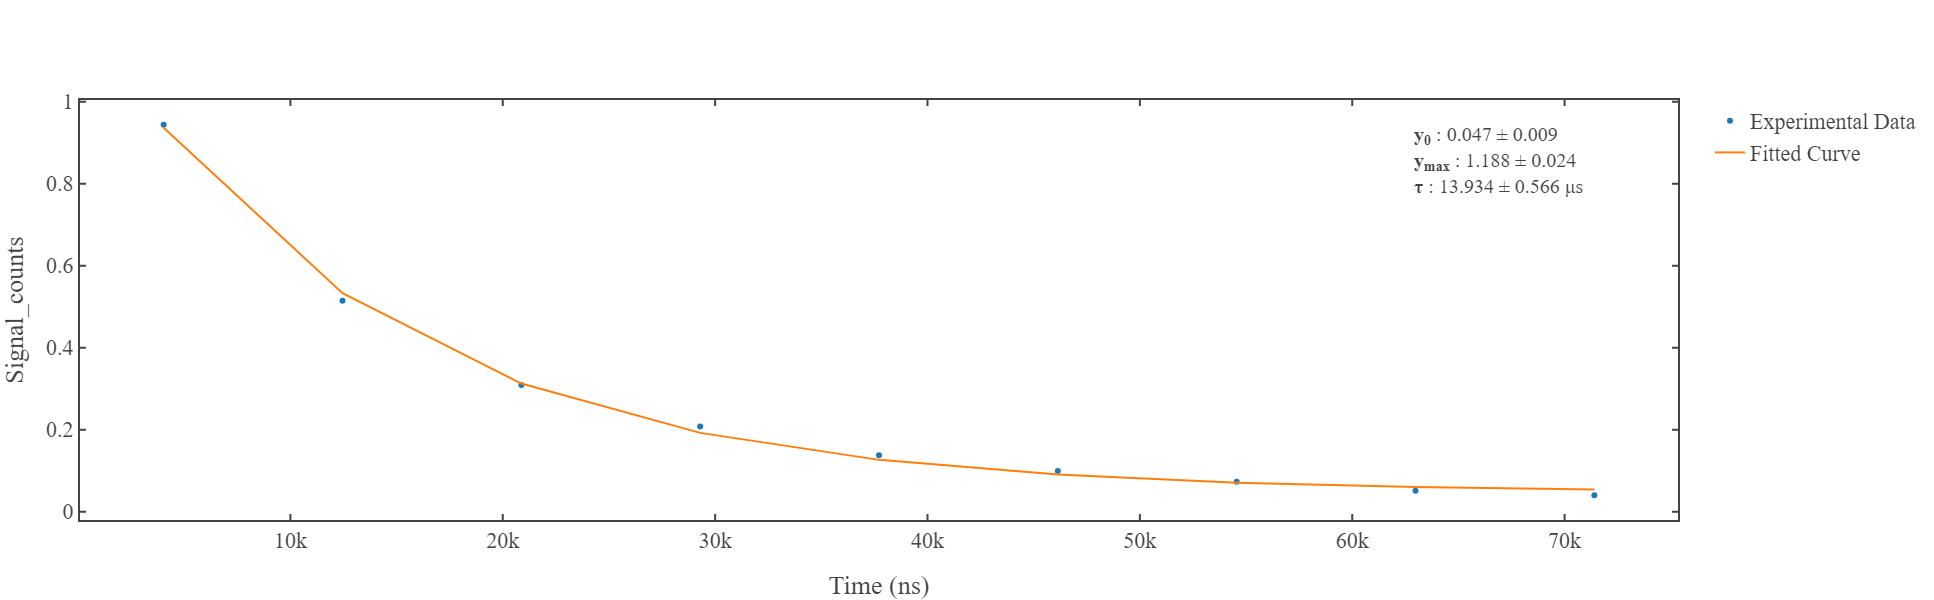

In [197]:
# Plotting the Fitted Curve
fig = go.Figure()
fig.add_scatter(x=x_old,y=y_old,mode='markers',name='Experimental Data' )
fig.add_scatter(x=xNew,y=yNew,mode='lines',name='Fitted Curve') 
fig.update_layout(template = fig_template)
fig.update_xaxes(title_text = "Time (ns)"); fig.update_yaxes(title_text = "Signal_counts")
fig.add_annotation(
    xref="x domain", yref="y domain",align = "left",
    x=0.95, y=0.95,
    text=f"<b>y<sub>0</sub></b> : {np.round(coefficient[-3],3)} &plusmn; {np.round(error_bars[-3],3)}\
    <br><b>y<sub>max</sub></b> : {np.round(coefficient[-2],3)} &plusmn; {np.round(error_bars[-2],3)}\
    <br><b>\u03C4</b> : {np.round(coefficient[-1]/1e3,3)} &plusmn; {np.round(error_bars[-1]/1e3,3)} &mu;s",
    showarrow=False,
    font_family="Times New Roman",font_size=20
)
#allowed saving formats : 'html','svg','pdf','png','jpeg','webp'
image_save(image_directory_name,file_name,fig_to_save=fig,extension='html') 
fig.show()